## Libraries

In [1]:
# System library imports
from pathlib import Path

# Third-party imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Load Data

In [3]:
# Define paths
root = Path.cwd().parent
data_dir = root / 'data'

# Load Lyme disease data
df = pd.read_csv(data_dir / 'UKHSA-2017-2022-Lyme-Disease.csv')
print(df.head(3))
print(df.tail(3))

   Year       Council  Case  Population  Incidence  Lower_95CI  Upper_95CI
0  2017          Adur   1.0     63721.0    1.56934     0.03973     8.74381
1  2017     Allerdale   3.0     97213.0    3.08601     0.63641     9.01862
2  2017  Amber Valley   4.0    125898.0    3.17718     0.86567     8.13483
      Year      Council  Case  Population  Incidence  Lower_95CI  Upper_95CI
1807  2022         Wyre   1.0    114809.0    0.87101     0.02205     4.85297
1808  2022  Wyre Forest   0.0    102328.0    0.00000     0.00000     3.60496
1809  2022         York   3.0    204551.0    1.46663     0.30245     4.28611


In [4]:
# Check the data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810 entries, 0 to 1809
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        1810 non-null   int64  
 1   Council     1810 non-null   object 
 2   Case        1792 non-null   float64
 3   Population  1792 non-null   float64
 4   Incidence   1792 non-null   float64
 5   Lower_95CI  1792 non-null   float64
 6   Upper_95CI  1792 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 99.1+ KB


In [5]:
# Check for missing values
df.isna().sum()

Year           0
Council        0
Case          18
Population    18
Incidence     18
Lower_95CI    18
Upper_95CI    18
dtype: int64

# Load UK Shape File

In [7]:
# Load shapefile for geographical data
shap_file_path = data_dir / 'Upper Tier Local Authority Boundaries/UTLA_MCTY_DEC_2022_UK_BFC.shp'
geo_data = gpd.read_file(shap_file_path)

## Merge Shape File with Lyme Dataset

In [22]:
# Merge the shapefile with the Lyme disease data
df_shp = geo_data.merge(df, how='left', left_on='UTLA22NM', right_on='Council')
df_shp.fillna({'Incidence': 0}, inplace=True) 

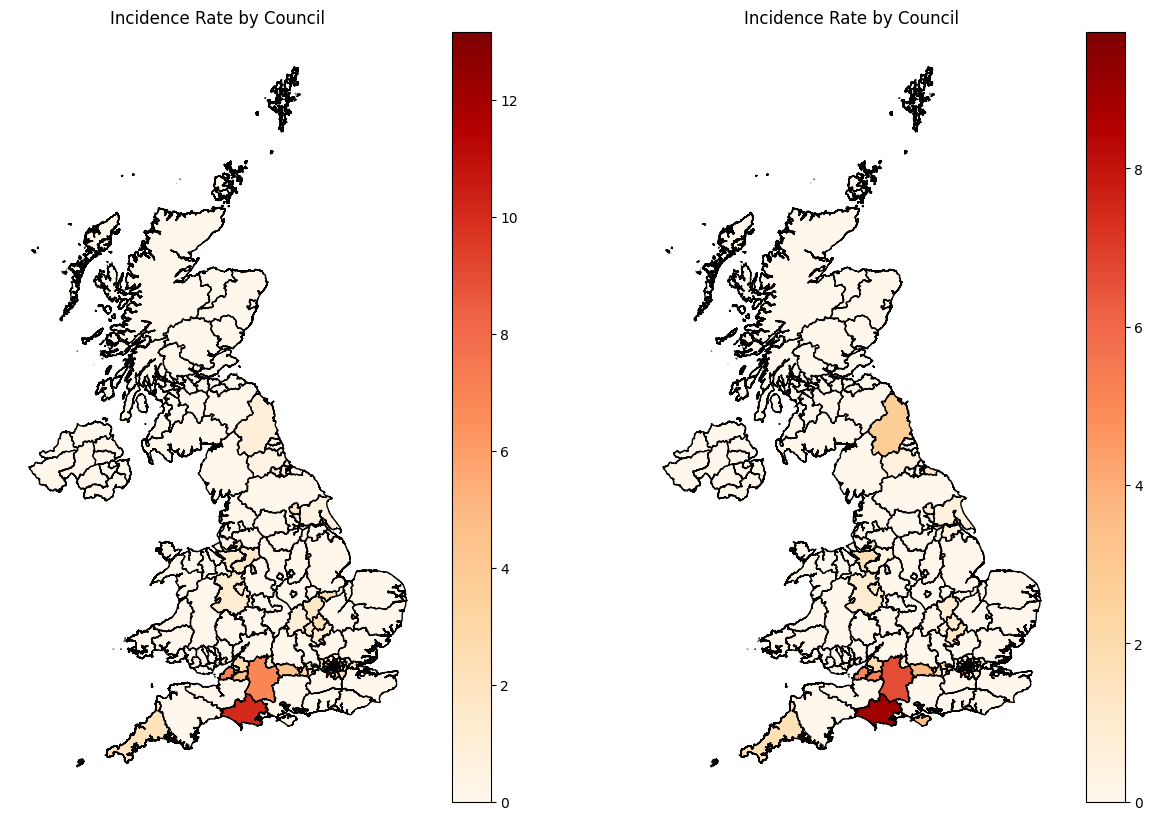

In [43]:
# Plot the data
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
df_2017 = df_shp[(df_shp['Year'] == 2017) | (df_shp['Year'].isna())]
df_2021 = df_shp[(df_shp['Year'] == 2021) | (df_shp['Year'].isna())]

# Plot for 2017
df_2017.plot(column='Incidence', ax=axes[0], legend=True, cmap='OrRd', edgecolor='black')
axes[0].set_title('Incidence Rate by Council')
axes[0].axis('off')

# Plot for 2021
df_2021.plot(column='Incidence', ax=axes[1], legend=True, cmap='OrRd', edgecolor='black')
axes[1].set_title('Incidence Rate by Council')
axes[1].axis('off')

plt.show()

In [9]:
# Save the merged data with shapefile
shapefile_name = 'lyme_disease_incidence_with_shapefile.geojson'
df_shp.to_file(data_dir / shapefile_name, driver='GeoJSON')